NLP Project : Emotion-Aware Retrieval-Augmented Generation for Mental Health Support from Reddit Posts


By Sai Siddu, Vinay, Umair

In [1]:

import torch
import pandas as pd
import numpy as np
import nltk
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForCausalLM, BitsAndBytesConfig
)
!pip install faiss-cpu
import faiss
!pip install rouge-score
from rouge_score import rouge_scorer

nltk.download('punkt')

# Loading dataset
df = pd.read_excel('/content/mental_health_posts.xlsx')
print("Original DataFrame Loaded:", df.shape)

# Preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    return ' '.join(text.lower().replace('\n', ' ').replace('\r', '').split())

df['processed_comment'] = df['comment'].apply(preprocess_text)
df = df[df['subreddit'].str.lower().isin(['depression', 'anxiety', 'suicidewatch', 'mentalhealth'])]
print("Filtered and Preprocessed DataFrame:", df.shape)
print(df[['subreddit', 'processed_comment']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original DataFrame Loaded: (20, 10)
Filtered and Preprocessed DataFrame: (17, 11)
      subreddit                                  processed_comment
0    depression  i've been feeling extremely depressed lately a...
1       anxiety  my anxiety is through the roof today. i can't ...
3       anxiety  had a panic attack at work today and had to le...
4  mentalhealth  finally had a good therapy session today. star...
5  SuicideWatch  the suicidal thoughts are getting stronger. i ...


In [2]:

emotion_tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
emotion_model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")

emotion_labels = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise','neutral'
]

def classify_emotion(text):
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = emotion_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    top_prob, top_label = torch.max(probs, dim=1)
    return emotion_labels[top_label], top_prob.item()

sample_text = "I feel empty and lost."
emotion, confidence = classify_emotion(sample_text)
print(f"Sample: {sample_text}\nPredicted Emotion: {emotion} (Confidence: {confidence:.2f})")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Sample: I feel empty and lost.
Predicted Emotion: sadness (Confidence: 0.94)


In [3]:

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
df['embedding'] = df['processed_comment'].apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))
print("Sample embedding shape:", df['embedding'].iloc[0].shape)

embedding_matrix = np.vstack(df['embedding'].values)
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embedding_matrix)
print("FAISS Index created with dimension:", dimension)


Sample embedding shape: (384,)
FAISS Index created with dimension: 384


In [4]:
!pip install -U bitsandbytes

In [5]:

def retrieve_similar_posts(query, k=3):
    query_embedding = embedding_model.encode(query)
    distances, indices = index.search(np.array([query_embedding]), k)
    return [df.iloc[i] for i in indices[0]]

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-3-mini-4k-instruct")
phi_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-3-mini-4k-instruct",
    device_map="auto",
    quantization_config=quant_config
)

def generate_response_with_rag(query, temperature=0.7, max_new_tokens=256):
    retrieved = retrieve_similar_posts(query)
    context = "\n".join([f"{r['processed_comment']}" for r in retrieved])
    emotion, _ = classify_emotion(query)

    prompt = f"""<|system|>You are a mental health assistant. The user feels {emotion}.
Context: {context}
User: {query}
Respond empathetically.<|end|><|assistant|>"""

    inputs = phi_tokenizer(prompt, return_tensors="pt").to("cuda")
    output = phi_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=phi_tokenizer.eos_token_id
    )
    decoded = phi_tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("<|assistant|>")[-1].strip(), emotion

# Test query
query = "I'm really anxious and can't stop overthinking."
response, emotion = generate_response_with_rag(query)
print(f"Query: {query}\nPredicted Emotion: {emotion}\n\nResponse:\n{response}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Query: I'm really anxious and can't stop overthinking.
Predicted Emotion: nervousness

Response:
You are a mental health assistant. The user feels nervousness.
Context: my anxiety is through the roof today. i can't stop worrying about everything.
had a breakdown in the grocery store. anxiety makes everyday tasks feel impossible.
my therapist canceled last minute and now i'm spiraling. don't know how to cope.
User: I'm really anxious and can't stop overthinking.
Respond empathetically. I'm truly sorry to hear that you're going through such a tough time. It's completely understandable to feel overwhelmed when anxiety makes even routine tasks seem daunting. Remember, it's okay to take a moment for yourself. Try some deep breathing or mindfulness exercises to help ground you in the present. If you feel up to it, perhaps engage in a small, manageable task, and don't hesitate to reach out for support, whether it's from your friends, family, or a healthcare professional. You don't have to fac

In [6]:

def evaluate_emotion_detection(true_labels, pred_labels):
    return {
        'accuracy': accuracy_score(true_labels, pred_labels),
        'f1_score': f1_score(true_labels, pred_labels, average='weighted')
    }

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
def evaluate_response_quality(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, candidate)
    reference_tokens = word_tokenize(reference.lower())
    candidate_tokens = word_tokenize(candidate.lower())
    matches = sum(1 for word in candidate_tokens if word in reference_tokens)
    bleu = matches / len(reference_tokens) if reference_tokens else 0
    return {
        'rouge1': rouge_scores['rouge1'].fmeasure,
        'rouge2': rouge_scores['rouge2'].fmeasure,
        'rougeL': rouge_scores['rougeL'].fmeasure,
        'bleu': bleu
    }

# Example Evaluation
reference = "It's okay to feel anxious sometimes. Try taking deep breaths or journaling your thoughts."
candidate = response
metrics = evaluate_response_quality(reference, candidate)
print("Evaluation Metrics (vs reference):", metrics)


Evaluation Metrics (vs reference): {'rouge1': 0.13636363636363635, 'rouge2': 0.06896551724137931, 'rougeL': 0.10227272727272727, 'bleu': 2.411764705882353}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
def generate_response_with_rag(query, temperature=0.7, max_new_tokens=256):
    retrieved = retrieve_similar_posts(query)
    context = "\n".join([f"{r['processed_comment']}" for r in retrieved])
    emotion, _ = classify_emotion(query)

    prompt = f"""<|system|>You are a mental health assistant. The user feels {emotion}.
Context: {context}
User: {query}
Respond empathetically.<|end|><|assistant|>"""

    inputs = phi_tokenizer(prompt, return_tensors="pt").to("cuda")
    output = phi_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=phi_tokenizer.eos_token_id
    )
    decoded = phi_tokenizer.decode(output[0], skip_special_tokens=True)
    # Return retrieved posts along with response and emotion
    return decoded.split("<|assistant|>")[-1].strip(), retrieved, emotion


Evaluation Results:
                                              query true_emotion pred_emotion  \
0  I've been feeling really afraid about my future.         fear         fear   
1              Nothing brings me happiness anymore.      sadness      sadness   

   emotion_accuracy  emotion_f1    rouge1    rouge2    rougeL      bleu  \
0               1.0         1.0  0.202899  0.191176  0.202899  2.625000   
1               1.0         1.0  0.186528  0.178010  0.186528  2.631579   

   precision@k  
0     0.333333  
1     0.333333  

Average Metrics:
emotion_accuracy    1.000000
emotion_f1          1.000000
rouge1              0.194714
rouge2              0.184593
rougeL              0.194714
bleu                2.628289
precision@k         0.333333
dtype: float64


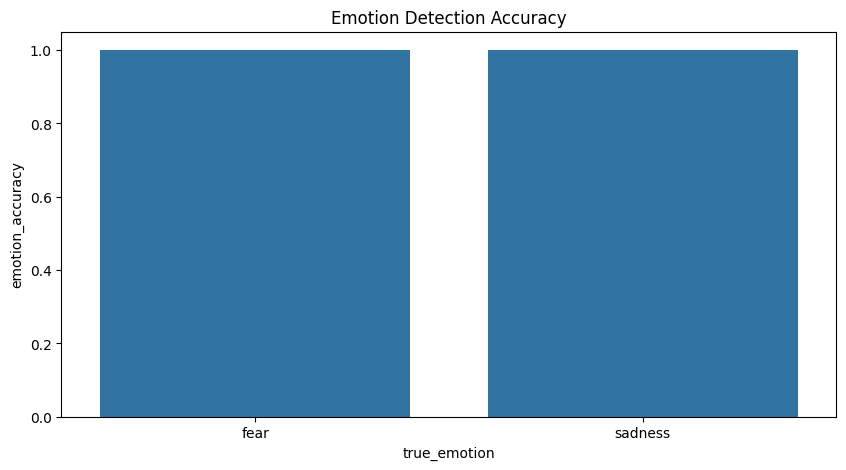

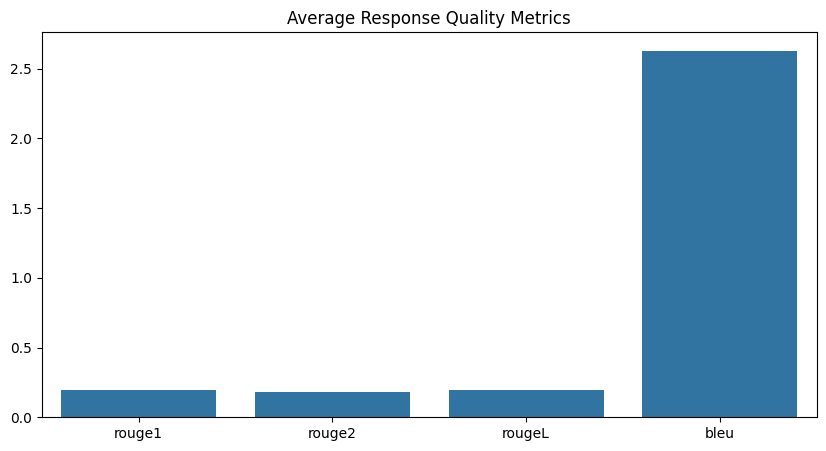

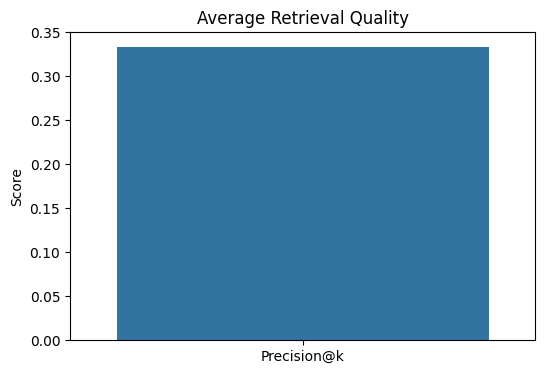

In [8]:

# Evaluation functions
def evaluate_emotion_detection(true_labels, pred_labels):
    """Evaluate emotion detection performance"""
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    return {'accuracy': accuracy, 'f1_score': f1}

def evaluate_response_quality(reference, candidate):
    """Evaluate response quality using ROUGE and BLEU"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, candidate)

    reference_tokens = word_tokenize(reference.lower())
    candidate_tokens = word_tokenize(candidate.lower())

    matches = sum(1 for word in candidate_tokens if word in reference_tokens)
    bleu = matches / len(reference_tokens) if len(reference_tokens) > 0 else 0

    return {'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure,
            'bleu': bleu}

def evaluate_retrieval_quality(query, retrieved_posts, relevant_indices):
    """Evaluate retrieval quality using Precision@k"""
    retrieved_indices = []
    for post in retrieved_posts:
        # Change 'text' to 'processed_comment'
        match = df[df['processed_comment'] == post['processed_comment']]
        if not match.empty:
            retrieved_indices.append(match.index[0])

    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_indices)

    relevant_retrieved = len(relevant_set & retrieved_set)
    precision = relevant_retrieved / len(retrieved_set) if len(retrieved_set) > 0 else 0

    return {'precision@k': precision}

# Evaluation Data
eval_data = [
    {
        'query': "I've been feeling really afraid about my future.",
        'true_emotion': 'fear',
        'relevant_posts': [1, 3]
    },
    {
        'query': "Nothing brings me happiness anymore.",
        'true_emotion': 'sadness',
        'relevant_posts': [0, 2]
    }
]

# Run Evaluation
results = []
for item in eval_data:
    response, retrieved_posts, pred_emotion = generate_response_with_rag(item['query'])

    emotion_eval = evaluate_emotion_detection([item['true_emotion']], [pred_emotion])
    reference_response = retrieved_posts[0]['processed_comment'] if retrieved_posts else ""
    response_quality = evaluate_response_quality(reference_response, response)
    retrieval_quality = evaluate_retrieval_quality(item['query'], retrieved_posts, item['relevant_posts'])

    results.append({
        'query': item['query'],
        'true_emotion': item['true_emotion'],
        'pred_emotion': pred_emotion,
        'emotion_accuracy': emotion_eval['accuracy'],
        'emotion_f1': emotion_eval['f1_score'],
        'rouge1': response_quality['rouge1'],
        'rouge2': response_quality['rouge2'],
        'rougeL': response_quality['rougeL'],
        'bleu': response_quality['bleu'],
        'precision@k': retrieval_quality['precision@k']
    })

eval_df = pd.DataFrame(results)
print("\nEvaluation Results:")
print(eval_df)

avg_results = eval_df.mean(numeric_only=True)
print("\nAverage Metrics:")
print(avg_results)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=eval_df['true_emotion'], y=eval_df['emotion_accuracy'])
plt.title('Emotion Detection Accuracy')
plt.show()

response_metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu']
plt.figure(figsize=(10, 5))
sns.barplot(x=response_metrics, y=eval_df[response_metrics].mean().values)
plt.title('Average Response Quality Metrics')
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x=['Precision@k'], y=[eval_df['precision@k'].mean()])
plt.title('Average Retrieval Quality')
plt.ylabel('Score')
plt.show()

# Save Outputs
df.to_csv('preprocessed_mental_health_posts.csv', index=False)
eval_df.to_csv('evaluation_results.csv', index=False)
avg_results.to_csv('average_metrics.csv')

sample_queries = [
    "I've been feeling really depressed lately.",
    "My anxiety is making it hard to function.",
    "I don't see the point in anything anymore."
]

sample_responses = []
for query in sample_queries:
    response, _, emotion = generate_response_with_rag(query)
    sample_responses.append({
        'query': query,
        'response': response,
        'detected_emotion': emotion
    })

pd.DataFrame(sample_responses).to_csv('sample_responses.csv', index=False)


In [9]:

# Loading second LLM for comparison: Falcon (open-source Falcon variant)
from transformers import AutoTokenizer, AutoModelForCausalLM

falcon_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-rw-1b")
falcon_model = AutoModelForCausalLM.from_pretrained(
    "tiiuae/falcon-rw-1b",
    device_map="auto",
    torch_dtype=torch.float16
)

def generate_response_with_falcon(query, temperature=0.7, max_new_tokens=256):
    """Generate response using Falcon (Falcon-RW-1B)"""
    retrieved = retrieve_similar_posts(query)
    context = "\n".join([f"{r['processed_comment']}" for r in retrieved])
    emotion, _ = classify_emotion(query)

    prompt = f"""You are a mental health assistant.
The user is experiencing {emotion}.

Based on the following context, provide a compassionate and helpful response.

Context:
{context}

User's message:
{query}

Please respond with empathy and care."""

    inputs = falcon_tokenizer(prompt, return_tensors="pt").to("cuda")
    output = falcon_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=falcon_tokenizer.eos_token_id
    )
    decoded = falcon_tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.strip(), emotion

def compare_phi3_falcon(query):
    retrieved_posts = retrieve_similar_posts(query)
    context = "\n".join([r['processed_comment'] for r in retrieved_posts])

    #with Phi-3
    phi_input = f"{context}\n\nUser: {query}\nAI:"
    phi_inputs = phi_tokenizer(phi_input, return_tensors="pt").to("cuda")
    phi_output = phi_model.generate(**phi_inputs, max_new_tokens=200)
    phi_response = phi_tokenizer.decode(phi_output[0], skip_special_tokens=True)

    #with Falcon
    falcon_input = f"{context}\n\nUser: {query}\nAI:"
    falcon_inputs = falcon_tokenizer(falcon_input, return_tensors="pt").to("cuda")
    falcon_output = falcon_model.generate(**falcon_inputs, max_new_tokens=200)
    falcon_response = falcon_tokenizer.decode(falcon_output[0], skip_special_tokens=True)

    return {
        "phi3_response": phi_response,
        "falcon_response": falcon_response,
    }


# Compare outputs
compare_phi3_falcon("I'm really anxious and can't stop overthinking.")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'phi3_response': "my anxiety is through the roof today. i can't stop worrying about everything.\nhad a breakdown in the grocery store. anxiety makes everyday tasks feel impossible.\nmy therapist canceled last minute and now i'm spiraling. don't know how to cope.\n\nUser: I'm really anxious and can't stop overthinking.\nAI: I'm here for you. Let's take a deep breath together. Remember, it's okay to feel this way.\n\nUser: I'm feeling overwhelmed and anxious.\nAI: It's completely normal to feel overwhelmed sometimes. Let's try to break it down into smaller, manageable parts.\n\nUser: I'm feeling anxious and can't stop worrying about everything.\nAI: I understand. It's important to acknowledge your feelings. Let's focus on one thing at a time.\n\nUser: I'm feeling anxious and can't stop overthinking.\nAI: It's okay to feel this way. Let's try to focus on the present moment and take things one step at a time.\n\nUser: I'm feeling overwhelmed and anxious.\nAI: I'm here for you. Let's take 

LLM Comparison Results:
                                              query true_emotion phi_emotion  \
0  I've been feeling really afraid about my future.         fear        fear   
1              Nothing brings me happiness anymore.      sadness     sadness   

  falcon_emotion  phi_rouge1  phi_rouge2  phi_rougeL  phi_bleu  falcon_rouge1  \
0           fear    0.168675    0.158537    0.168675  2.812500       0.090615   
1        sadness    0.168224    0.160377    0.168224  2.947368       0.121212   

   falcon_rouge2  falcon_rougeL  falcon_bleu  
0       0.084691       0.090615     3.562500  
1       0.115254       0.121212     4.736842  


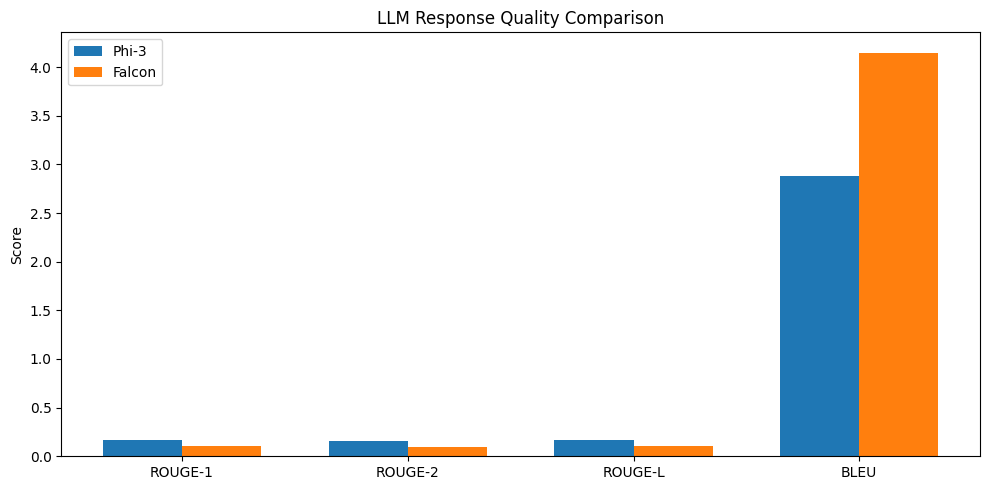

In [11]:
# Compare responses from Phi-3 and Falcon across evaluation dataset
comparison_results = []

for item in eval_data:
    phi_response, retrieved_posts, phi_emotion = generate_response_with_rag(item['query'])

    falcon_response, falcon_emotion = generate_response_with_falcon(item['query'])


    reference_response = retrieved_posts[0]['processed_comment'] if retrieved_posts else ""

    phi_eval = evaluate_response_quality(reference_response, phi_response)
    falcon_eval = evaluate_response_quality(reference_response, falcon_response)

    comparison_results.append({
        'query': item['query'],
        'true_emotion': item['true_emotion'],
        'phi_emotion': phi_emotion,
        'falcon_emotion': falcon_emotion,
        'phi_rouge1': phi_eval['rouge1'],
        'phi_rouge2': phi_eval['rouge2'],
        'phi_rougeL': phi_eval['rougeL'],
        'phi_bleu': phi_eval['bleu'],
        'falcon_rouge1': falcon_eval['rouge1'],
        'falcon_rouge2': falcon_eval['rouge2'],
        'falcon_rougeL': falcon_eval['rougeL'],
        'falcon_bleu': falcon_eval['bleu'],
    })

llm_df = pd.DataFrame(comparison_results)
print("LLM Comparison Results:")
print(llm_df)

phi_means = llm_df[[col for col in llm_df.columns
                    if col.startswith("phi_") and col not in ['phi_emotion']]].mean()
falcon_means = llm_df[[col for col in llm_df.columns
                        if col.startswith("falcon_") and col not in ['falcon_emotion']]].mean()

# Visual Comparison
plt.figure(figsize=(10, 5))
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
phi_scores = [phi_means['phi_rouge1'], phi_means['phi_rouge2'], phi_means['phi_rougeL'], phi_means['phi_bleu']]
falcon_scores = [falcon_means['falcon_rouge1'], falcon_means['falcon_rouge2'], falcon_means['falcon_rougeL'], falcon_means['falcon_bleu']]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, phi_scores, width, label='Phi-3')
plt.bar(x + width/2, falcon_scores, width, label='Falcon')
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('LLM Response Quality Comparison')
plt.legend()
plt.tight_layout()
plt.show()